# Imports

In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

np.set_printoptions(precision=3, suppress=True)
from IPython.display import clear_output
plt.set_cmap('cividis')


from scipy import interpolate

#specific Neural Network imports

import tensorflow as tf
import keras
import keras_tuner
import keras.backend as K

from keras_tuner import RandomSearch, Hyperband, GridSearch, BayesianOptimization, HyperModel, Objective, Tuner, HyperParameters
from keras import layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model, save_model


#imports for scikit learn, for general ML techniques


from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.decomposition import PCA

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()



<Figure size 640x480 with 0 Axes>

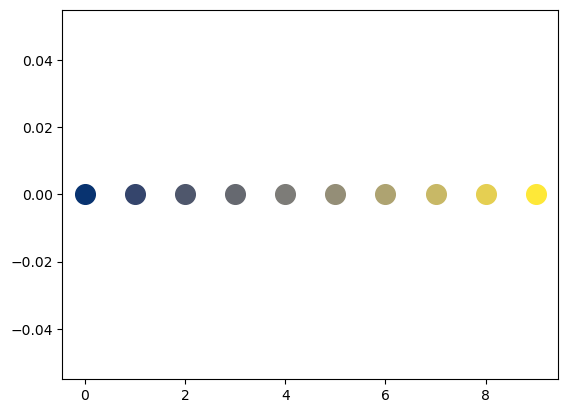

In [3]:
#Creating some colors for use throughout the notebook
cmap = matplotlib.cm.get_cmap('cividis')
colors = [cmap(i) for i in np.arange(0.1, 1.1, 0.1)]
for i, col in enumerate(colors):
  plt.scatter(i, 0, color=colors[i], s=200)

# Get the data

## Importing and preprocess

In [4]:
def getData_profile(filename, outputs=[0], features_start=7):
    #read out the data from a csv file and remove n_period column

    data = pd.read_csv(filename, sep=',', header=0)

    if len(outputs)>1:
        y_df = data.iloc[:, outputs[0]:outputs[-1]+1]
    else:
        y_df = data.iloc[:, outputs[0]]
        
    X_df = data.iloc[:, features_start::]
        
    return y_df, X_df

#y_df, X_df = getData_profile('sims_custom\dens_data_subtr.csv', outputs=[0, 1, 2])
y_df, X_df = getData_profile('05_files\JET_ELM_subtr.csv', outputs=[4, 5])



def add_noise(img, var):
    '''Add random noise to an image'''

    noise = np.random.normal(0, var, img.shape)
    img_noised= noise + img
    return img_noised

def preProcessing_PCA(y_df, X_df, comps=5, test_size=0.2, random_state=0, noise=True, var_noise=0.01):
    #Do all the preprocessing steps for training and validation:
    #Properly expand dimensions
    #Split and renormalize to train max
    #add gaussian noise

    X = np.expand_dims(np.array(X_df), -1) #needed for the convolutional structure
    y = np.array(y_df)


    sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y[:, 0]))

    x_train, y_train = X[train_idx], y[train_idx]
    x_test, y_test = X[test_idx], y[test_idx]
    
    highest_peak = np.amax(abs(x_train))
    print(highest_peak)
    print(np.amin(x_train))
    x_train /= highest_peak
    x_test  /= highest_peak
    new_max = np.amax(abs(x_train))
    print(new_max)
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(x_train):
            x_train[i] = add_noise(sample, var_noise*new_max)
        for i, sample in enumerate(x_test):
            x_test[i] = add_noise(sample, var_noise*new_max)

    pca = PCA(n_components=comps)
    pca.fit(x_train[:, :-1, 0])

    x_pca_train = pca.transform(x_train[:, :-1, 0])
    x_pca_test = pca.transform(x_test[:, :-1, 0])

    return x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca


n_PCA_comps = 20

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X_df, comps=n_PCA_comps, noise=True, var_noise=0.01)


x_train_1, x_pca_train_1, x_test_1, x_pca_test_1, y_train_1, y_test_1, pca_model_1 = preProcessing_PCA(y_df, X_df, comps=n_PCA_comps, noise=False, var_noise=0.01)


3.20935
-3.20935
1.0
3.20935
-3.20935
1.0


## Getting a categorical encoding for the mode number

In [5]:
y_train_ampl = np.expand_dims(y_train[:, 0], 1)
y_train_mode = tf.keras.utils.to_categorical(np.expand_dims(y_train[:, 1], 1), num_classes=5)
y_test_ampl = np.expand_dims(y_test[:, 0], 1)
y_test_mode = tf.keras.utils.to_categorical(np.expand_dims(y_test[:, 1], 1), num_classes=5)

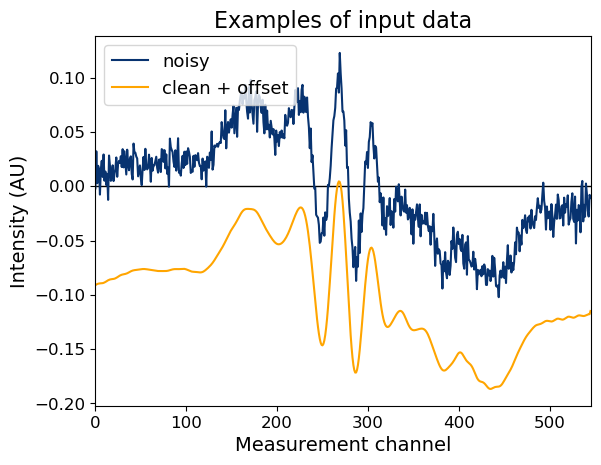

In [6]:
fig, ax = plt.subplots()

ax.hlines(0, xmin=0, xmax=x_train.shape[1], color='black', linewidth=1)
ax.plot(x_train[800, :, 0], c=colors[0], label='noisy')
ax.plot(x_train_1[800, :, 0]-.1, c='orange', label='clean + offset')
ax.legend(loc='upper left', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Examples of input data', fontsize=16)
ax.set_ylabel(r'Intensity (AU)', fontsize=14)
ax.set_xlabel(r'Measurement channel', fontsize=14)

plt.xlim(0, x_train.shape[1])

plt.savefig('05_files/figures/input_data.pdf', bbox_inches='tight')

## Exploring the PCA analysis for this case

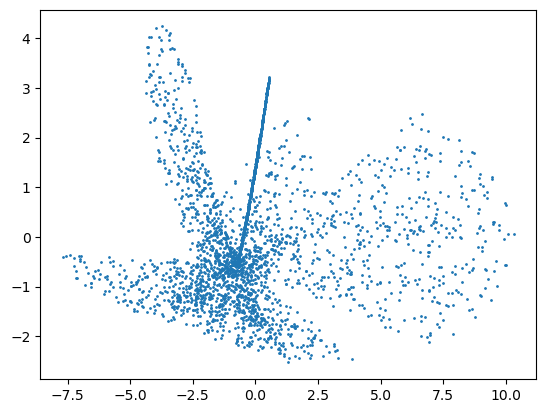

In [7]:
plt.scatter(x_pca_train[:, 0], x_pca_train[:, 1], s=1)

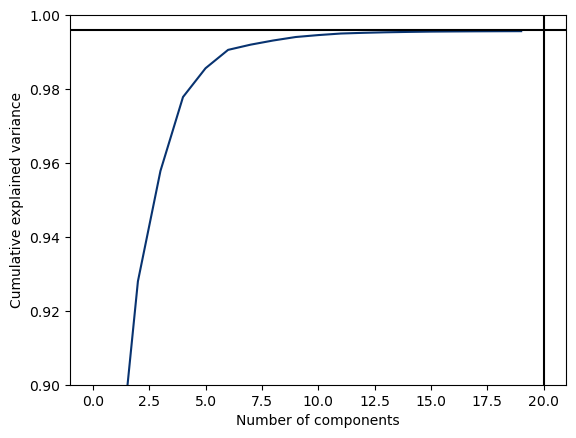

In [8]:
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), c=colors[0])
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.ylim(.9, 1)
plt.axhline(0.996, c='black')
plt.axvline(20, c='black')

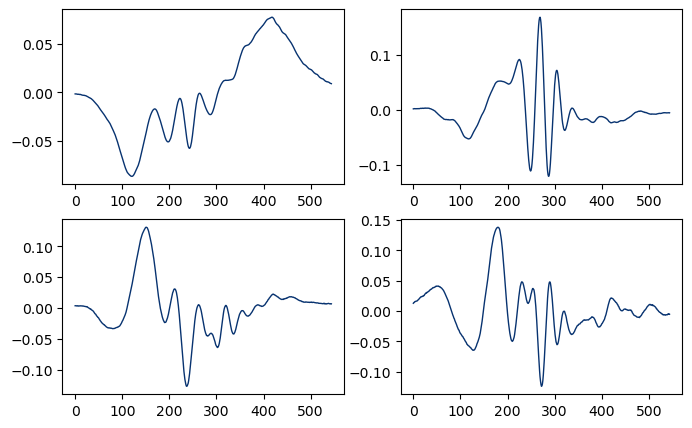

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

ax[0, 0].plot(pca_model.components_[0], linewidth=1, label='1', c=colors[0])
ax[0, 1].plot(pca_model.components_[1], linewidth=1, label='2', c=colors[0])
ax[1, 0].plot(pca_model.components_[2], linewidth=1, label='3', c=colors[0])
ax[1, 1].plot(pca_model.components_[3], linewidth=1, label='4', c=colors[0])

(0.0, 546.0)

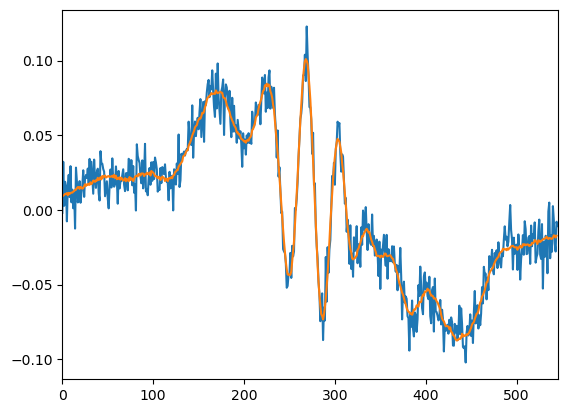

In [10]:
plt.plot(x_train[800, :, 0])

plt.plot(pca_model.inverse_transform(x_pca_train[800]))
plt.xlim(0, x_train.shape[1])


## The loss functions

# Model generation

In [11]:
x_train.shape

(2884, 546, 1)

In [12]:
def create_ELM_model(hp):


    profile_input = keras.Input(shape=(546, 1), name="profile")  # Variable-length sequence of ints

    x = layers.AveragePooling1D(pool_size=5, strides=2, padding='same', name='pool1')(profile_input)

    for i in range(hp.Int("num__conv_layers", 2, 3, default=3)):
        kernelsize = int(np.max([3, (2**(4-i)-1)]))
        x = layers.Conv1D(np.min([8*(2**i), 32]), kernel_size=kernelsize, padding='same', name=f'conv{i+1}')(x)
        x = layers.LeakyReLU()(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2, strides=2,padding='same', name=f'pool{i+2}')(x)

    x = layers.Flatten(name='flatten')(x)


    rate = hp.Choice(f'droprate', [.1, .15, .2, .25], default=.15)
    for i in range(hp.Int("num__dens_layers", 1, 3, default=3)):
        if hp.Boolean("dropout", default=True):
            x = keras.layers.Dropout(rate=rate, name=f'drop{i+1}')(x)
        x = layers.Dense(units=hp.Int(f"units_{i+1}", min_value=64, max_value=512, step=64, default=960)
                                        , activation='relu', name=f'dens{i+1}')(x)


    output_amplitude = layers.Dense(1, activation='linear', name='ampl')(x)
    output_mode_num = layers.Dense(5, activation='softmax', name='mode')(x)

    model = keras.Model(inputs=profile_input, outputs=[output_amplitude, output_mode_num])

    optimizer = getattr(tf.keras.optimizers, "Adam")(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=0.0025))
    model.compile(optimizer=optimizer, loss=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.CategoricalCrossentropy()] , loss_weights=[25, 1], metrics=['mae', 'accuracy'])

    return model

In [13]:
x_val = x_train[:576]
x_tr = x_train[576:]
y_tr_ampl = y_train_ampl[576:]   
y_tr_mode = y_train_mode[576:]
y_val_ampl = y_train_ampl[:576]
y_val_mode = y_train_mode[:576]

In [53]:
hp = keras_tuner.HyperParameters()

model = create_ELM_model(hp)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('05_files/tuning/optimised_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history = model.fit({'profile': x_tr},
                            {'ampl': y_tr_ampl, 'mode': y_tr_mode},
                            validation_data=({'profile': x_val}, {'ampl': y_val_ampl, 'mode': y_val_mode}),
                            epochs=400, batch_size=256, callbacks=[es, mc_full], verbose=1)
                          

Epoch 1/400
10/10 [==============================] - 3s 128ms/step - loss: 4570.8643 - ampl_loss: 182.7672 - mode_loss: 1.6848 - ampl_mae: 4.5992 - ampl_accuracy: 4.3328e-04 - mode_mae: 0.3067 - mode_accuracy: 0.2465 - val_loss: 2.5419 - val_ampl_loss: 0.0375 - val_mode_loss: 1.6045 - val_ampl_mae: 0.1737 - val_ampl_accuracy: 0.0017 - val_mode_mae: 0.3196 - val_mode_accuracy: 0.2535
Epoch 2/400
10/10 [==============================] - 1s 97ms/step - loss: 5.3791 - ampl_loss: 0.1568 - mode_loss: 1.4602 - ampl_mae: 0.2517 - ampl_accuracy: 0.0013 - mode_mae: 0.2975 - mode_accuracy: 0.2886 - val_loss: 2.4992 - val_ampl_loss: 0.0362 - val_mode_loss: 1.5952 - val_ampl_mae: 0.1695 - val_ampl_accuracy: 0.0017 - val_mode_mae: 0.3188 - val_mode_accuracy: 0.1875
Epoch 3/400
10/10 [==============================] - 1s 105ms/step - loss: 2.8914 - ampl_loss: 0.0625 - mode_loss: 1.3281 - ampl_mae: 0.1756 - ampl_accuracy: 0.0013 - mode_mae: 0.2867 - mode_accuracy: 0.4315 - val_loss: 2.4089 - val_ampl_

C:\Users\ewout\AppData\Local\Temp\ipykernel_153020\4230994838.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ylim(0)


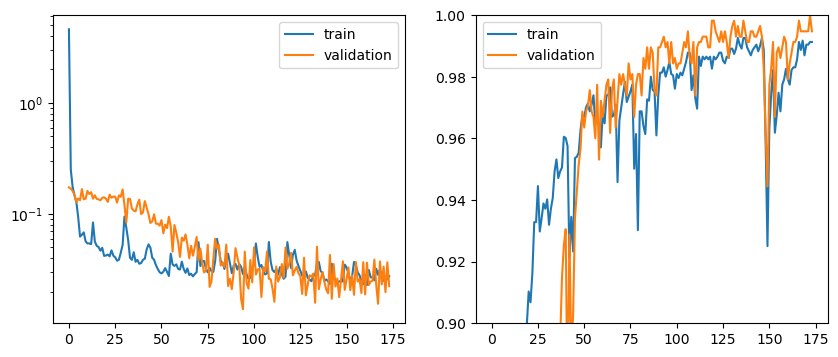

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(history.history['ampl_mae'], label='train')
ax[0].plot(history.history['val_ampl_mae'], label='validation')

ax[1].plot(history.history['mode_accuracy'], label='train')
ax[1].plot(history.history['val_mode_accuracy'], label='validation')

ax[0].set_yscale('log')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(0)
ax[1].set_ylim(0.9, 1)
#plt.axhline(0.03, c='black')
plt.show()

In [55]:
model = load_model('05_files/tuning/optimised_model.h5')
model.accuracy = model.evaluate(x_test, [y_test_ampl, y_test_mode], verbose=0)[6]
print(f'Accuracy of mode number prediction is {model.accuracy}')
model.mae = model.evaluate(x_test, [y_test_ampl, y_test_mode], verbose=0)[3]
print(f'MAE of amplitude prediction is {model.mae}')

Accuracy of mode number prediction is 0.9930747747421265
MAE of amplitude prediction is 0.00664413021877408


23/23 [==============================] - 0s 10ms/step


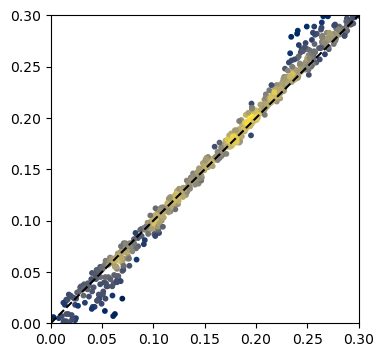

In [56]:

a = model.predict({'profile': x_test})[:][0]

radius = 0.01
density = np.zeros_like(a)
for i, (point_x, point_y) in enumerate(zip(a, y_test_ampl)):
    distances = np.sqrt((a - point_x)**2 + (y_test_ampl - point_y)**2)
    density[i] = np.sum(distances < radius)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(a, y_test_ampl, s=10, c=density, alpha=1)
ax.set_xlim(0, .3)
ax.set_ylim(0, .3) 
ax.set_aspect('equal')
ax.plot(np.linspace(0, .3, 100), np.linspace(0, .3, 100), '--',  c='black')

# Tuning hyperparameters

In [62]:
#This lets you tune single parameters or a few at once, with the rest set to standard value.

#For the others, the default is set inside the function create_resolved_model

hp = keras_tuner.HyperParameters()

#so only the following are tunable
hp.Choice(f'droprate', [.1, .15, .2, .25])  #Do this one later!!
hp.Int(f"units_{3}", min_value=128, max_value=128, step=64)






128

In [63]:
tuner = GridSearch(
    hypermodel=create_ELM_model,
    hyperparameters=hp,
    # Prevents unlisted parameters from being tuned
    tune_new_entries=False,
    objective="val_loss",
    max_trials=4,
    executions_per_trial=3,
    overwrite=True,
    directory="05_files/tuning",
    project_name="ELM_tuning_2"
)

"""
tuner = BayesianOptimization(
    hypermodel=create_ELM_model,
    hyperparameters=hp,
    # Prevents unlisted parameters from being tuned
    tune_new_entries=False,
    objective="val_loss",
    max_trials=100,
    alpha=2e-3,
    beta=2.6,
    executions_per_trial=1,
    overwrite=True,
    directory="05_files/tuning",
    project_name="ELM_tuning"
)"""

'\ntuner = BayesianOptimization(\n    hypermodel=create_ELM_model,\n    hyperparameters=hp,\n    # Prevents unlisted parameters from being tuned\n    tune_new_entries=False,\n    objective="val_loss",\n    max_trials=100,\n    alpha=2e-3,\n    beta=2.6,\n    executions_per_trial=1,\n    overwrite=True,\n    directory="05_files/tuning",\n    project_name="ELM_tuning"\n)'

In [64]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
droprate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.15, 0.2, 0.25], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 128, 'step': 64, 'sampling': 'linear'}


In [65]:
tuner.search({'profile': x_tr},
            {'ampl': y_tr_ampl, 'mode': y_tr_mode},
            validation_data=({'profile': x_val}, {'ampl': y_val_ampl, 'mode': y_val_mode}),
            epochs=100, batch_size=128)

Trial 4 Complete [00h 04m 50s]
val_loss: 0.030864374091227848

Best val_loss So Far: 0.017795812338590622
Total elapsed time: 00h 19m 40s
INFO:tensorflow:Oracle triggered exit


In [66]:
vals = tuner.get_best_hyperparameters()[0].values
vals

{'droprate': 0.1,
 'units_3': 128,
 'num__conv_layers': 3,
 'num__dens_layers': 3,
 'dropout': True,
 'units_1': 960,
 'units_2': 960,
 'learning_rate': 0.0025}

In [67]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 546, 1))
best_model.summary()
save_model(best_model, "05_files/tuning/best_model.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile (InputLayer)           [(None, 546, 1)]     0           []                               
                                                                                                  
 pool1 (AveragePooling1D)       (None, 273, 1)       0           ['profile[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 273, 8)       128         ['pool1[0][0]']                  
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 273, 8)       0           ['conv1[0][0]']                  
                                                                                              

In [14]:
model_result = load_model("05_files/tuning/best_model.h5")

# Retraining ideal model

In [69]:
vals = tuner.get_best_hyperparameters(3)
vals[0].values

{'droprate': 0.1,
 'units_3': 128,
 'num__conv_layers': 3,
 'num__dens_layers': 3,
 'dropout': True,
 'units_1': 960,
 'units_2': 960,
 'learning_rate': 0.0025}

In [24]:
hp = keras_tuner.HyperParameters()

#so only the following are tunable
hp.Choice(f'droprate', [.1])  
hp.Int(f"units_{3}", min_value=128, max_value=128, step=64)

model = create_ELM_model(hp)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('05_files/tuning/optimised_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history = model.fit({'profile': x_train},
                            {'ampl': y_train_ampl, 'mode': y_train_mode},
                            validation_data=({'profile': x_test}, {'ampl': y_test_ampl, 'mode': y_test_mode}),
                            epochs=400, batch_size=256, callbacks=[es, mc_full], verbose=1)
                          

Epoch 1/400
12/12 [==============================] - 4s 153ms/step - loss: 1940.9164 - ampl_loss: 77.5599 - mode_loss: 1.9204 - ampl_mae: 2.5185 - ampl_accuracy: 0.0014 - mode_mae: 0.3153 - mode_accuracy: 0.2077 - val_loss: 2.1964 - val_ampl_loss: 0.0241 - val_mode_loss: 1.5932 - val_ampl_mae: 0.1336 - val_ampl_accuracy: 0.0028 - val_mode_mae: 0.3186 - val_mode_accuracy: 0.2299
Epoch 2/400
12/12 [==============================] - 1s 89ms/step - loss: 2.5017 - ampl_loss: 0.0387 - mode_loss: 1.5332 - ampl_mae: 0.1354 - ampl_accuracy: 0.0014 - mode_mae: 0.2918 - mode_accuracy: 0.2992 - val_loss: 2.2605 - val_ampl_loss: 0.0266 - val_mode_loss: 1.5952 - val_ampl_mae: 0.1415 - val_ampl_accuracy: 0.0028 - val_mode_mae: 0.3188 - val_mode_accuracy: 0.3698
Epoch 3/400
12/12 [==============================] - 1s 80ms/step - loss: 1.5991 - ampl_loss: 0.0123 - mode_loss: 1.2923 - ampl_mae: 0.0858 - ampl_accuracy: 0.0014 - mode_mae: 0.2712 - mode_accuracy: 0.5146 - val_loss: 2.2011 - val_ampl_loss: 

In [25]:
model = load_model('05_files/tuning/optimised_model.h5')
"""
optimised_result = load_model("04_files/tuning/optimised_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
ssim_result = load_model("04_files/tuning/ssim_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
nrmse_result = load_model("04_files/tuning/nrmse_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
"""


'\noptimised_result = load_model("04_files/tuning/optimised_model.h5", custom_objects={\'loss_split\': loss_split, \'nrmse\': nrmse, \'SSIMLoss\': SSIMLoss, \'ssim\': ssim, \'psnr\': psnr, \'mae\': mae})\nssim_result = load_model("04_files/tuning/ssim_model.h5", custom_objects={\'loss_split\': loss_split, \'nrmse\': nrmse, \'SSIMLoss\': SSIMLoss, \'ssim\': ssim, \'psnr\': psnr, \'mae\': mae})\nnrmse_result = load_model("04_files/tuning/nrmse_model.h5", custom_objects={\'loss_split\': loss_split, \'nrmse\': nrmse, \'SSIMLoss\': SSIMLoss, \'ssim\': ssim, \'psnr\': psnr, \'mae\': mae})\n'

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile (InputLayer)           [(None, 546, 1)]     0           []                               
                                                                                                  
 pool1 (AveragePooling1D)       (None, 273, 1)       0           ['profile[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 273, 8)       128         ['pool1[0][0]']                  
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 273, 8)       0           ['conv1[0][0]']                  
                                                                                              

In [26]:
model.accuracy = model.evaluate(x_test, [y_test_ampl, y_test_mode], verbose=0)[6]
print(f'Accuracy of mode number prediction is {model.accuracy}')
model.mae = model.evaluate(x_test, [y_test_ampl, y_test_mode], verbose=0)[2]
print(f'MAE of amplitude prediction is {model.mae}')

Accuracy of mode number prediction is 0.9944598078727722
MAE of amplitude prediction is 0.016993707045912743


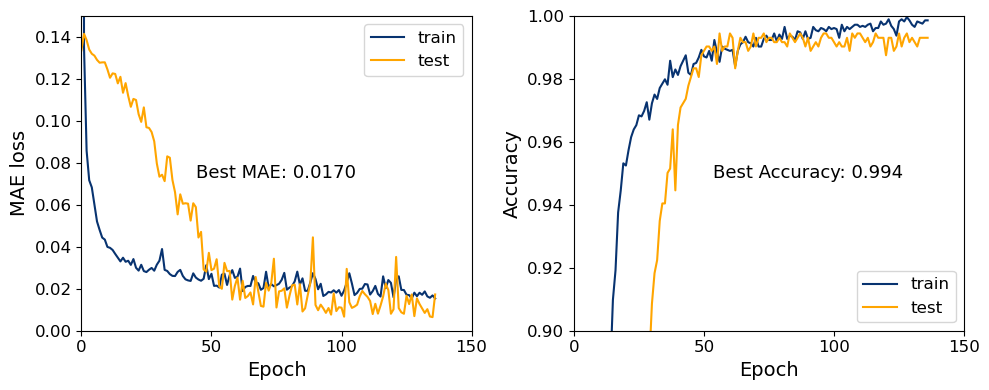

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(history.history['ampl_mae'], c=colors[0], label='train')
ax[0].plot(history.history['val_ampl_mae'], c='orange',  label='test')

ax[1].plot(history.history['mode_accuracy'], c=colors[0], label='train')
ax[1].plot(history.history['val_mode_accuracy'], c='orange', label='test')

#ax[0].set_yscale('log')
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
ax[0].set_ylim(0, .15)
ax[1].set_ylim(0.9, 1)
ax[0].set_xlim(0, 150)
ax[1].set_xlim(0, 150)
ax[0].set_xticks([0, 50, 100, 150])
ax[1].set_xticks([0, 50, 100, 150])
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
#plt.axhline(0.03, c='black')
ax[0].set_xlabel('Epoch', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('MAE loss', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[0].annotate(f'Best MAE: {model.mae:.4f}', xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=13)
ax[1].annotate(f'Best Accuracy: {model.accuracy:.3f}', xy=(0.6, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=13)
plt.tight_layout()
plt.savefig('05_files/figures/training_history.pdf', dpi=300)
plt.show()

23/23 [==============================] - 0s 11ms/step


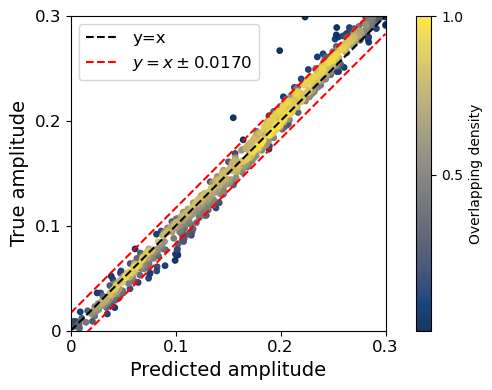

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde


a = model.predict({'profile': x_test})[:][0]
"""
radius = 0.01
density = np.zeros_like(a)
for i, (point_x, point_y) in enumerate(zip(a, y_test_ampl)):
    distances = np.sqrt((a - point_x)**2 + (y_test_ampl - point_y)**2)
    density[i] = np.sum(distances < radius) -1

density = density / np.max(density)
"""

xy = np.vstack([a[:, 0], y_test_ampl[:, 0]])
z = gaussian_kde(xy, bw_method=.28)(xy)
idx = z.argsort()
x, y, z = a[idx], y_test_ampl[idx], z[idx]

z = 1.012*z / np.max(z) -0.0115

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sc = ax.scatter(x, y, s=15, c=z, alpha=.9)

divider_1 = make_axes_locatable(ax)
cax = divider_1.append_axes("right", size="5%", pad=0.3)
plt.colorbar(sc, cax=cax, label='Overlapping density', ticks=[0., .5, 1])

ax.set_xlabel('Predicted amplitude', fontsize=14)
ax.set_ylabel('True amplitude', fontsize=14)
ax.set_xticks([0, 0.1, 0.2, 0.3])
ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.set_xticklabels([0, 0.1, 0.2, 0.3], fontsize=12)
ax.set_yticklabels([0, 0.1, 0.2, 0.3], fontsize=12)
ax.set_xlim(0, .3)
ax.set_ylim(0, .3) 
ax.set_aspect('equal')
ax.plot(np.linspace(0, .3, 100), np.linspace(0, .3, 100), '--',  c='black', label='y=x')
ax.plot(np.linspace(0, .3, 100), np.linspace(0.017, .317, 100), '--',  c='red', label=r'$y = x \pm 0.0170$')
ax.plot(np.linspace(0, .3, 100), np.linspace(-0.017, .283, 100), '--',  c='red')
ax.legend(fontsize=12)

plt.tight_layout()

In [26]:
def prediction(model):

    index = 0
    while index != -1:

        clear_output()
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

        
        preds = model.predict(x_test[index:index+1])[1][0]
        ax.scatter(np.arange(5), preds, label=f'certainty={np.amax(preds):.3f}')
        ax.scatter(np.arange(5), y_test_mode[index]-.1, label='ground truth')
        ax.set_ylim(0, 1.01)
        ax.set_xticks([0, 1, 2, 3, 4])
    
        plt.legend()
        plt.show()

        index = int(input(f"Select new index, -1 to stop: "))

    return

1/1 [==============================] - 0s 20ms/step


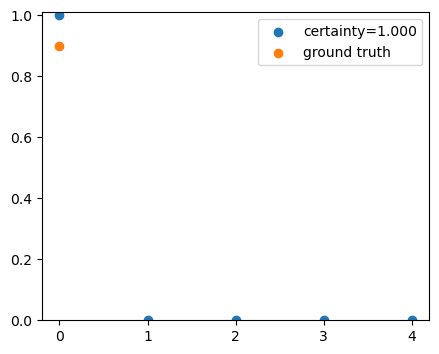

In [29]:
prediction(model)